# Data Collection

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,make_scorer,f1_score,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from joblib import dump
from xgboost import XGBClassifier
import optuna

warnings.filterwarnings('ignore')
pd.set_option('display.float_format',lambda x: '{:.2f}'.format(x))
np.set_printoptions(suppress=True)

In [9]:
df_customers = pd.read_csv('/content/drive/MyDrive/code Basics/Project-2/customers.csv')
df_bureau    = pd.read_csv('/content/drive/MyDrive/code Basics/Project-2/bureau_data.csv')
df_loans     = pd.read_csv('/content/drive/MyDrive/code Basics/Project-2/loans.csv')

In [10]:
df_customers.shape, df_bureau.shape, df_loans.shape

((50000, 12), (50000, 8), (50000, 15))

In [11]:
# merge all the files into one
df = pd.merge(df_customers,df_loans,on='cust_id')
df = pd.merge(df,df_bureau)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cust_id                      50000 non-null  object 
 1   age                          50000 non-null  int64  
 2   gender                       50000 non-null  object 
 3   marital_status               50000 non-null  object 
 4   employment_status            50000 non-null  object 
 5   income                       50000 non-null  int64  
 6   number_of_dependants         50000 non-null  int64  
 7   residence_type               49938 non-null  object 
 8   years_at_current_address     50000 non-null  int64  
 9   city                         50000 non-null  object 
 10  state                        50000 non-null  object 
 11  zipcode                      50000 non-null  int64  
 12  loan_id                      50000 non-null  object 
 13  loan_purpose    

In [13]:
df['default'] = df['default'].astype('int32')

# Data Preparation


## Data cleaning & preparation

In [56]:
# split the data into train test in order to avoid the DATA LEAKAGE
X = df.drop('default',axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.25,random_state=42)


In [57]:
df_train =  pd.concat([X_train,y_train],axis='columns')
df_test  =  pd.concat([X_test,y_test],axis='columns')
df_train.shape, df_test.shape

((37500, 33), (12500, 33))

In [58]:
df_train.isna().sum()

,0
cust_id,0
age,0
gender,0
marital_status,0
employment_status,0
income,0
number_of_dependants,0
residence_type,47
years_at_current_address,0
city,0


In [59]:
df_train.residence_type.unique()
residence_type_mode =df_train.residence_type.mode()[0]

In [60]:
df_train.residence_type = df_train.residence_type.fillna(residence_type_mode)
df_test.residence_type = df_test.residence_type.fillna(residence_type_mode)

In [61]:
df_train.duplicated().sum()

np.int64(0)

In [62]:
df_test.duplicated().sum()

np.int64(0)

In [63]:
df_train.columns

Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
       'income', 'number_of_dependants', 'residence_type',
       'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
       'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'disbursal_date', 'installment_start_dt', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio', 'default'],
      dtype='object')

In [64]:
categorical_cols = ['gender', 'marital_status', 'employment_status',
       'residence_type', 'city', 'state','loan_purpose',
       'loan_type']
numerical_cols = ['age', 'income', 'number_of_dependants', 'years_at_current_address',
       'zipcode', 'sanction_amount', 'loan_amount','processing_fee','gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio']


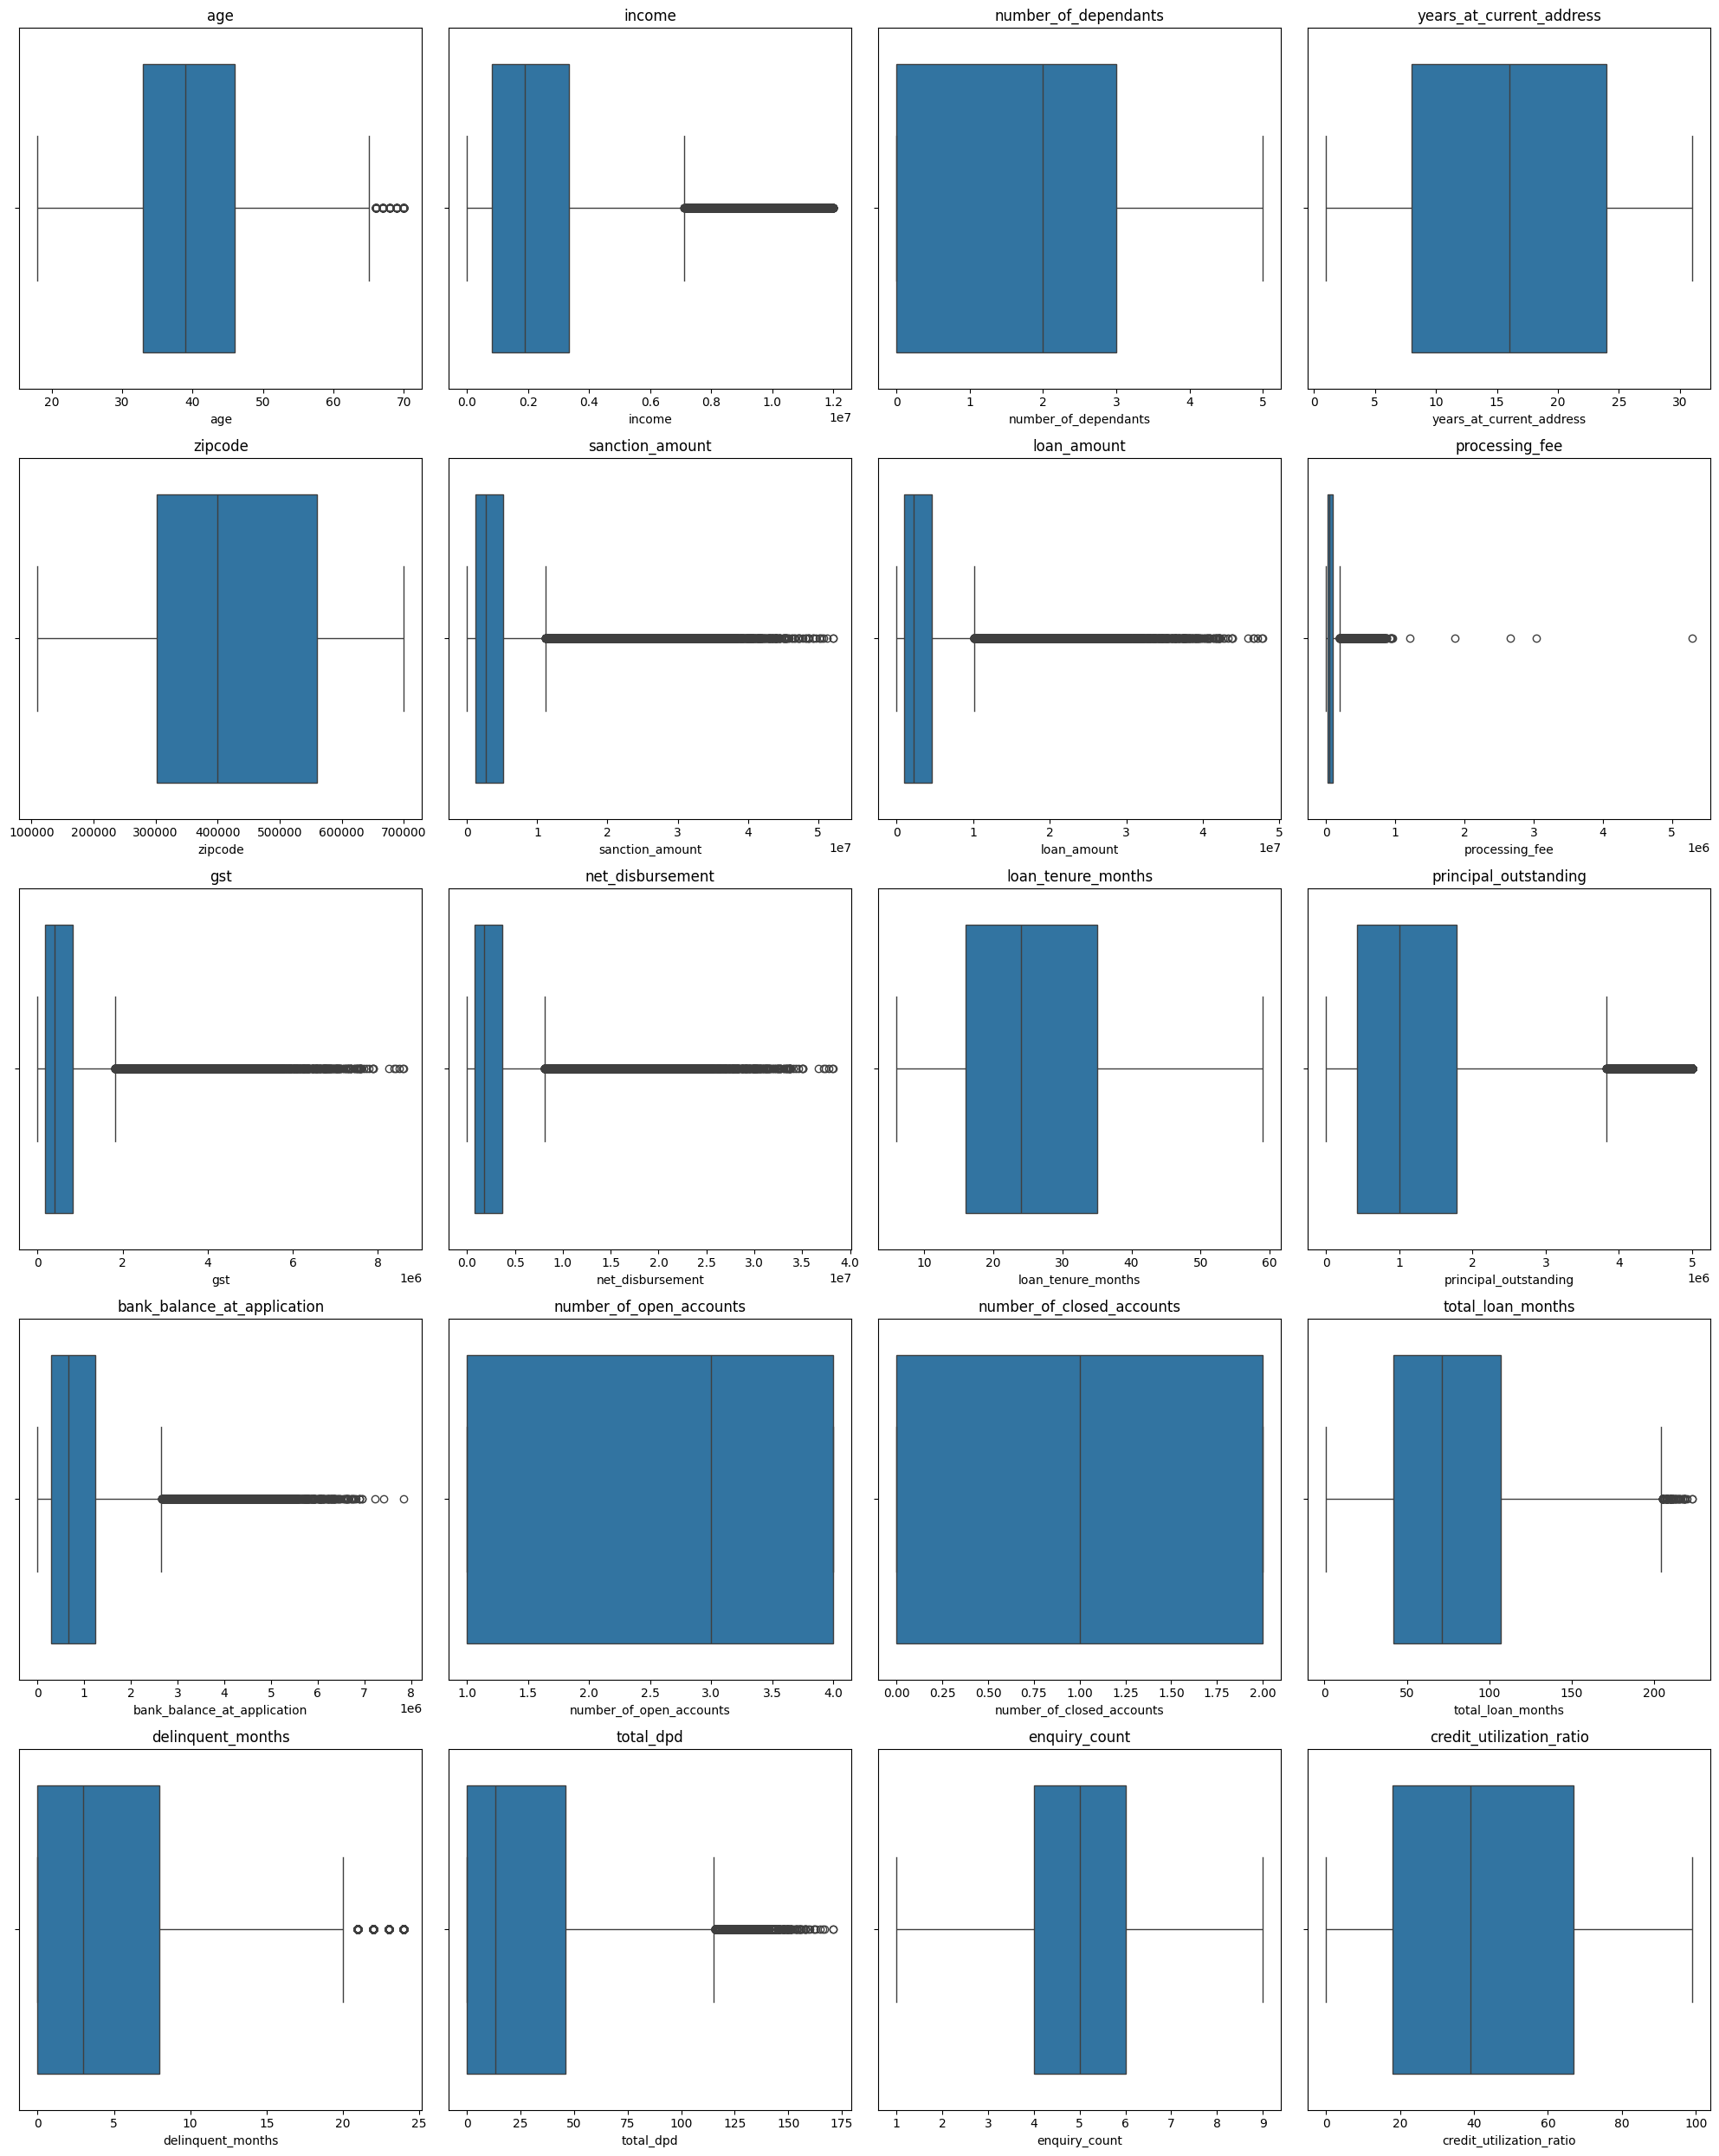

In [65]:
num_plots = len(numerical_cols)
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
axes = axes. flatten()

for i, col in enumerate(numerical_cols):
  sns.boxplot(x=df_train[col], ax=axes[i])
  axes[i].set_title(col)

for j in range(i + 1, num_rows * num_cols):
  axes[j].axis('off' )

plt.tight_layout()
plt.show()


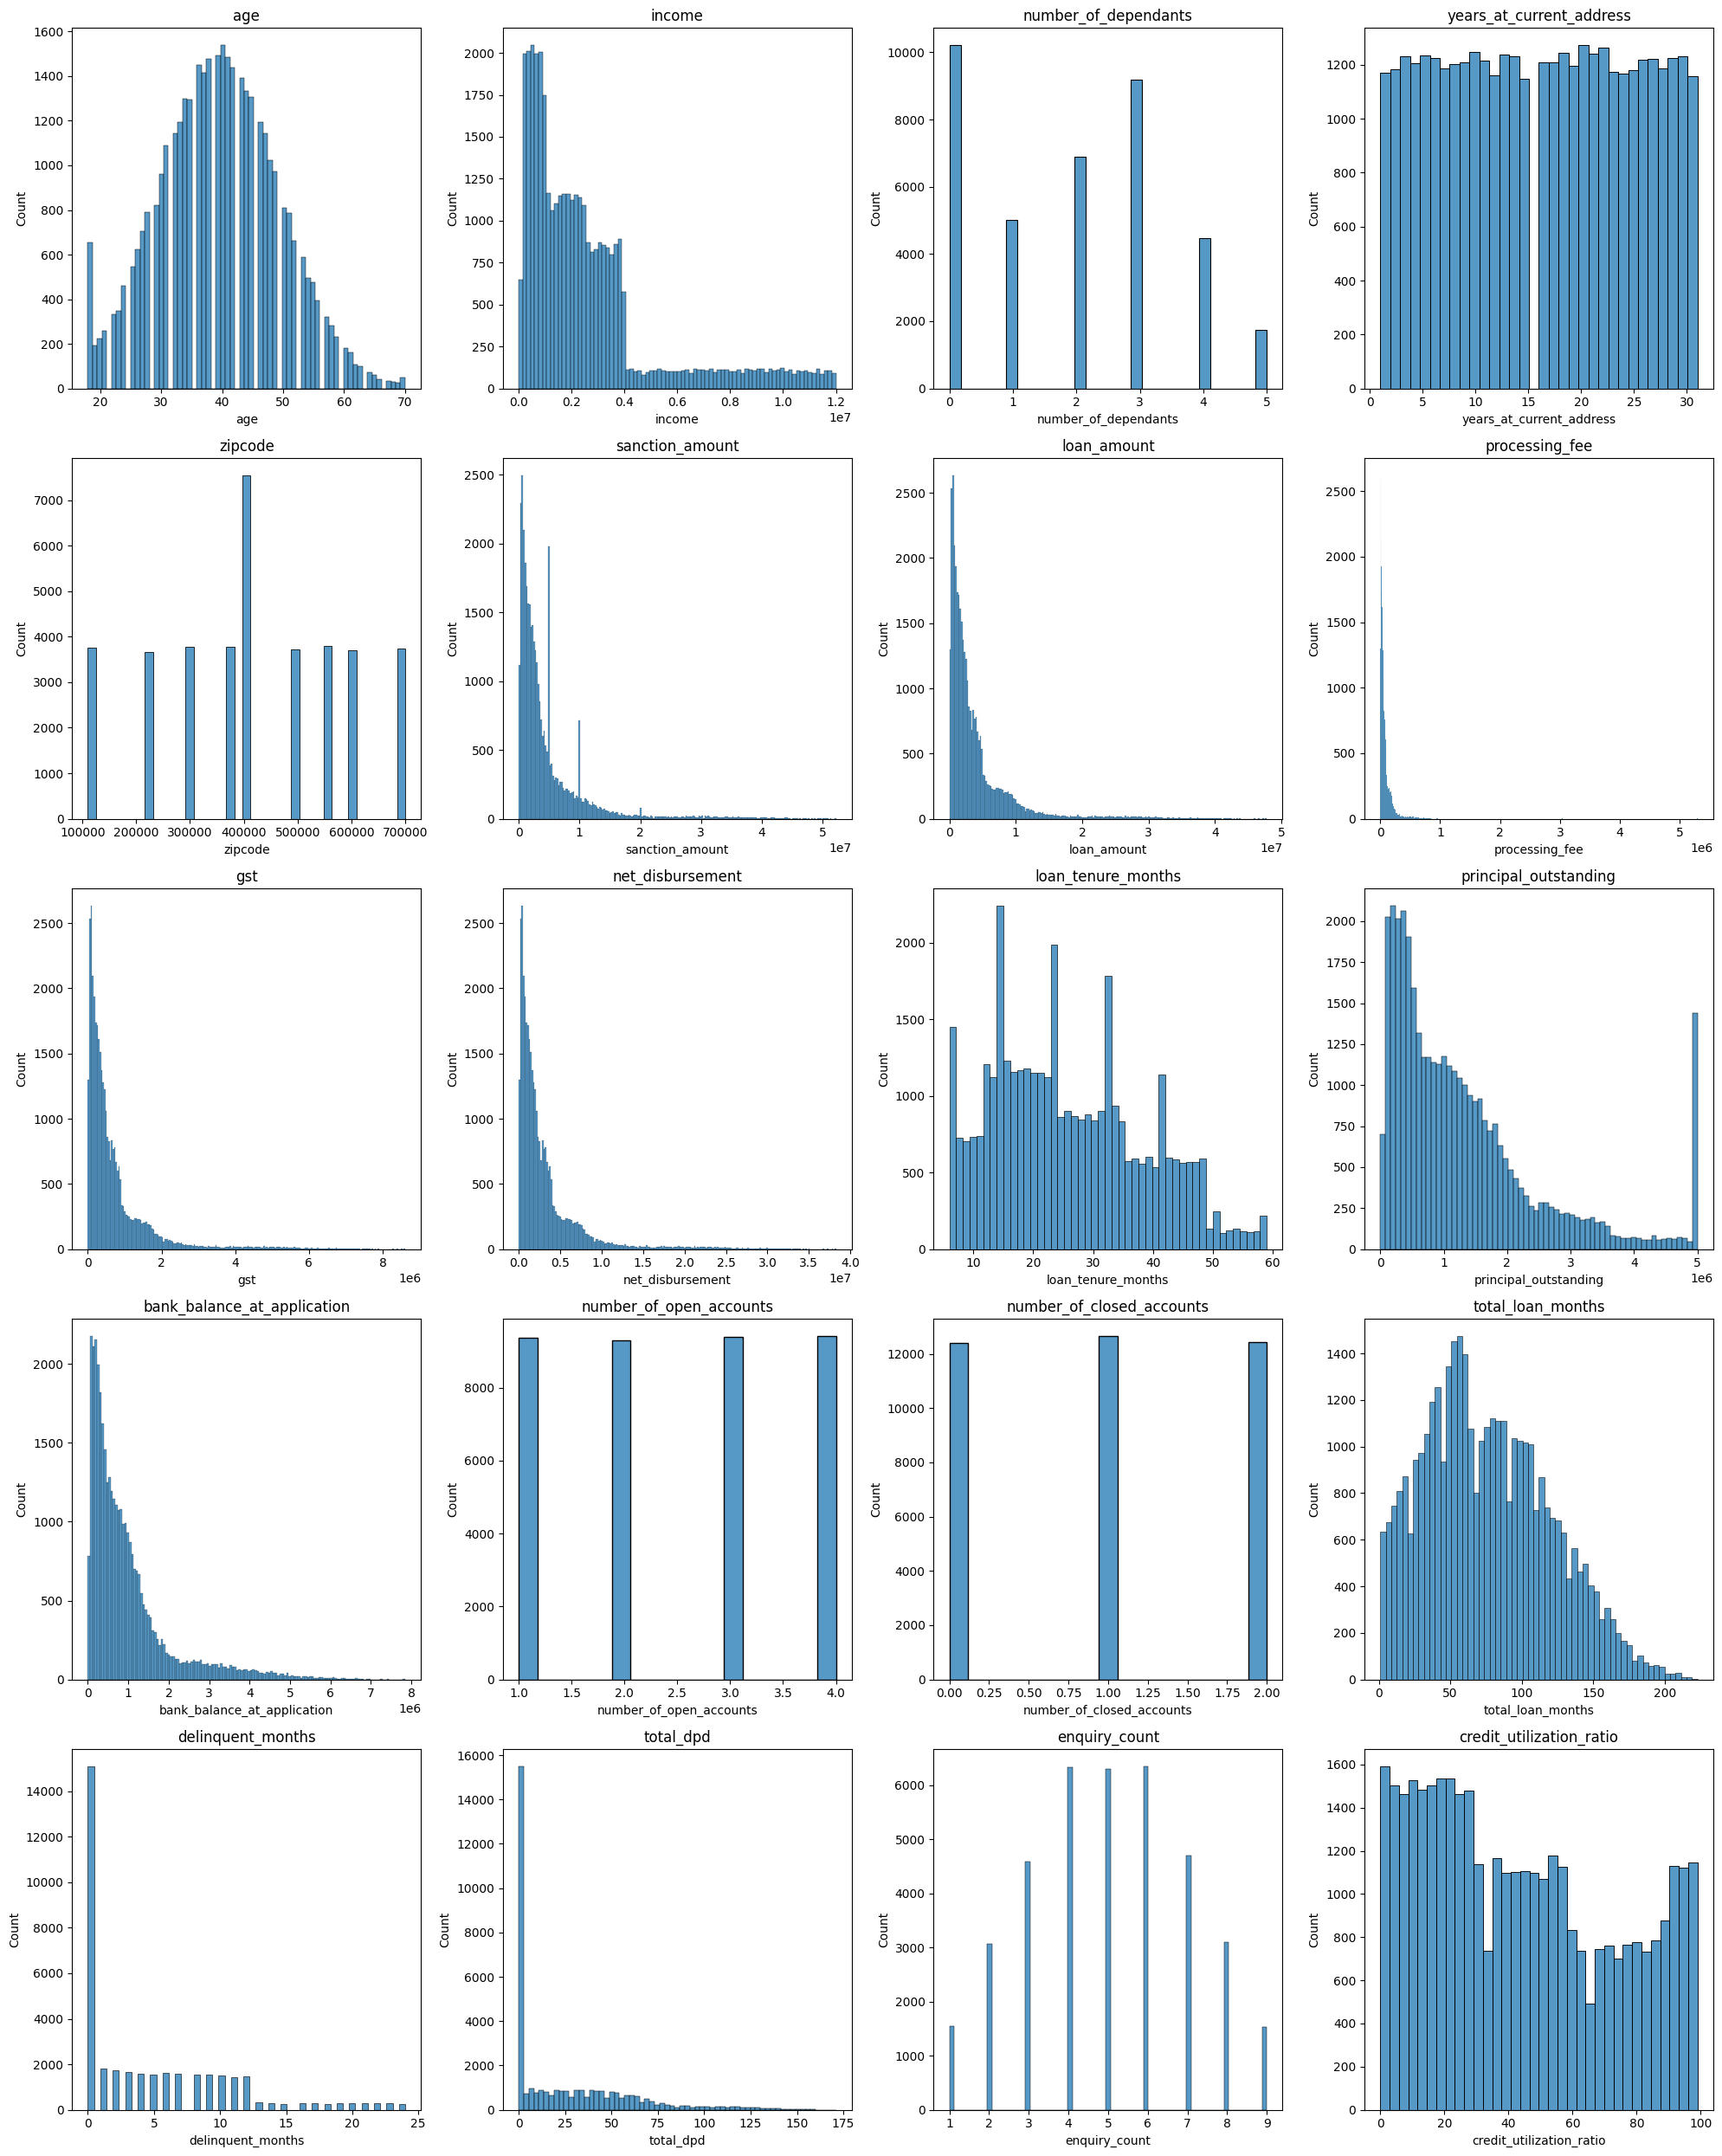

In [66]:
num_plots = len(numerical_cols)
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
axes = axes. flatten()

for i, col in enumerate(numerical_cols):
  sns.histplot(x=df_train[col], ax=axes[i])
  axes[i].set_title(col)

for j in range(i + 1, num_rows * num_cols):
  axes[j].axis('off' )

plt.tight_layout()
plt.show()

In [67]:
df_train.processing_fee.describe()

,processing_fee
count,37500.00
mean,80290.68
std,113128.14
min,0.00
25%,19220.00
50%,44600.00
75%,92420.00
max,5293543.52


In [68]:
df_train[(df_train.processing_fee/df_train.loan_amount)>0.03][['loan_amount','processing_fee']]

,loan_amount,processing_fee
23981,2234000,2669791.02
28174,966000,1214492.67
47089,1738000,1858964.77
29305,2616000,3036378.01
9898,3626000,5293543.52


In [69]:
df_train = df_train[(df_train.processing_fee/df_train.loan_amount)<0.03]
df_test = df_test[(df_test.processing_fee/df_test.loan_amount)<0.03]

In [70]:
for col in categorical_cols:
  print(f"{col:<20}  --->  {df_train[col].unique()}")

gender                --->  ['M' 'F']
marital_status        --->  ['Married' 'Single']
employment_status     --->  ['Self-Employed' 'Salaried']
residence_type        --->  ['Owned' 'Mortgage' 'Rented']
city                  --->  ['Hyderabad' 'Mumbai' 'Chennai' 'Bangalore' 'Pune' 'Kolkata' 'Ahmedabad'
 'Delhi' 'Lucknow' 'Jaipur']
state                 --->  ['Telangana' 'Maharashtra' 'Tamil Nadu' 'Karnataka' 'West Bengal'
 'Gujarat' 'Delhi' 'Uttar Pradesh' 'Rajasthan']
loan_purpose          --->  ['Home' 'Education' 'Personal' 'Auto' 'Personaal']
loan_type             --->  ['Secured' 'Unsecured']


In [71]:
df_train.loan_purpose = df_train['loan_purpose'].replace('Personaal','Personal')
df_test.loan_purpose = df_test['loan_purpose'].replace('Personaal','Personal')

## EDA

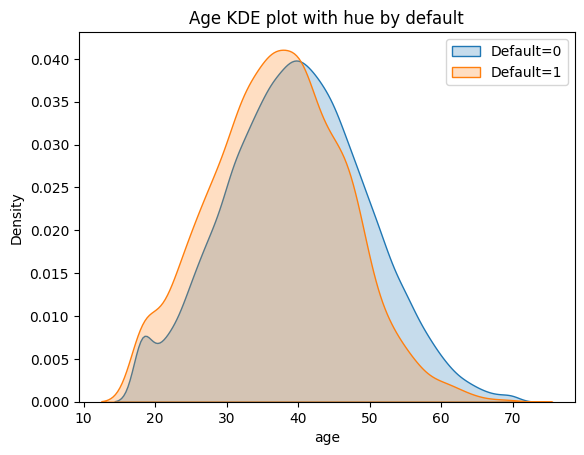

In [72]:
sns.kdeplot(df_train[df_train['default']==0]['age'],fill=True,label='Default=0')
sns.kdeplot(df_train[df_train['default']==1]['age'],fill=True,label='Default=1')
plt.title('Age KDE plot with hue by default')
plt.legend()
plt.show()

**- INSIGHT**
* orange graph is little bit shifted to left indicating the younger age is more likely to default

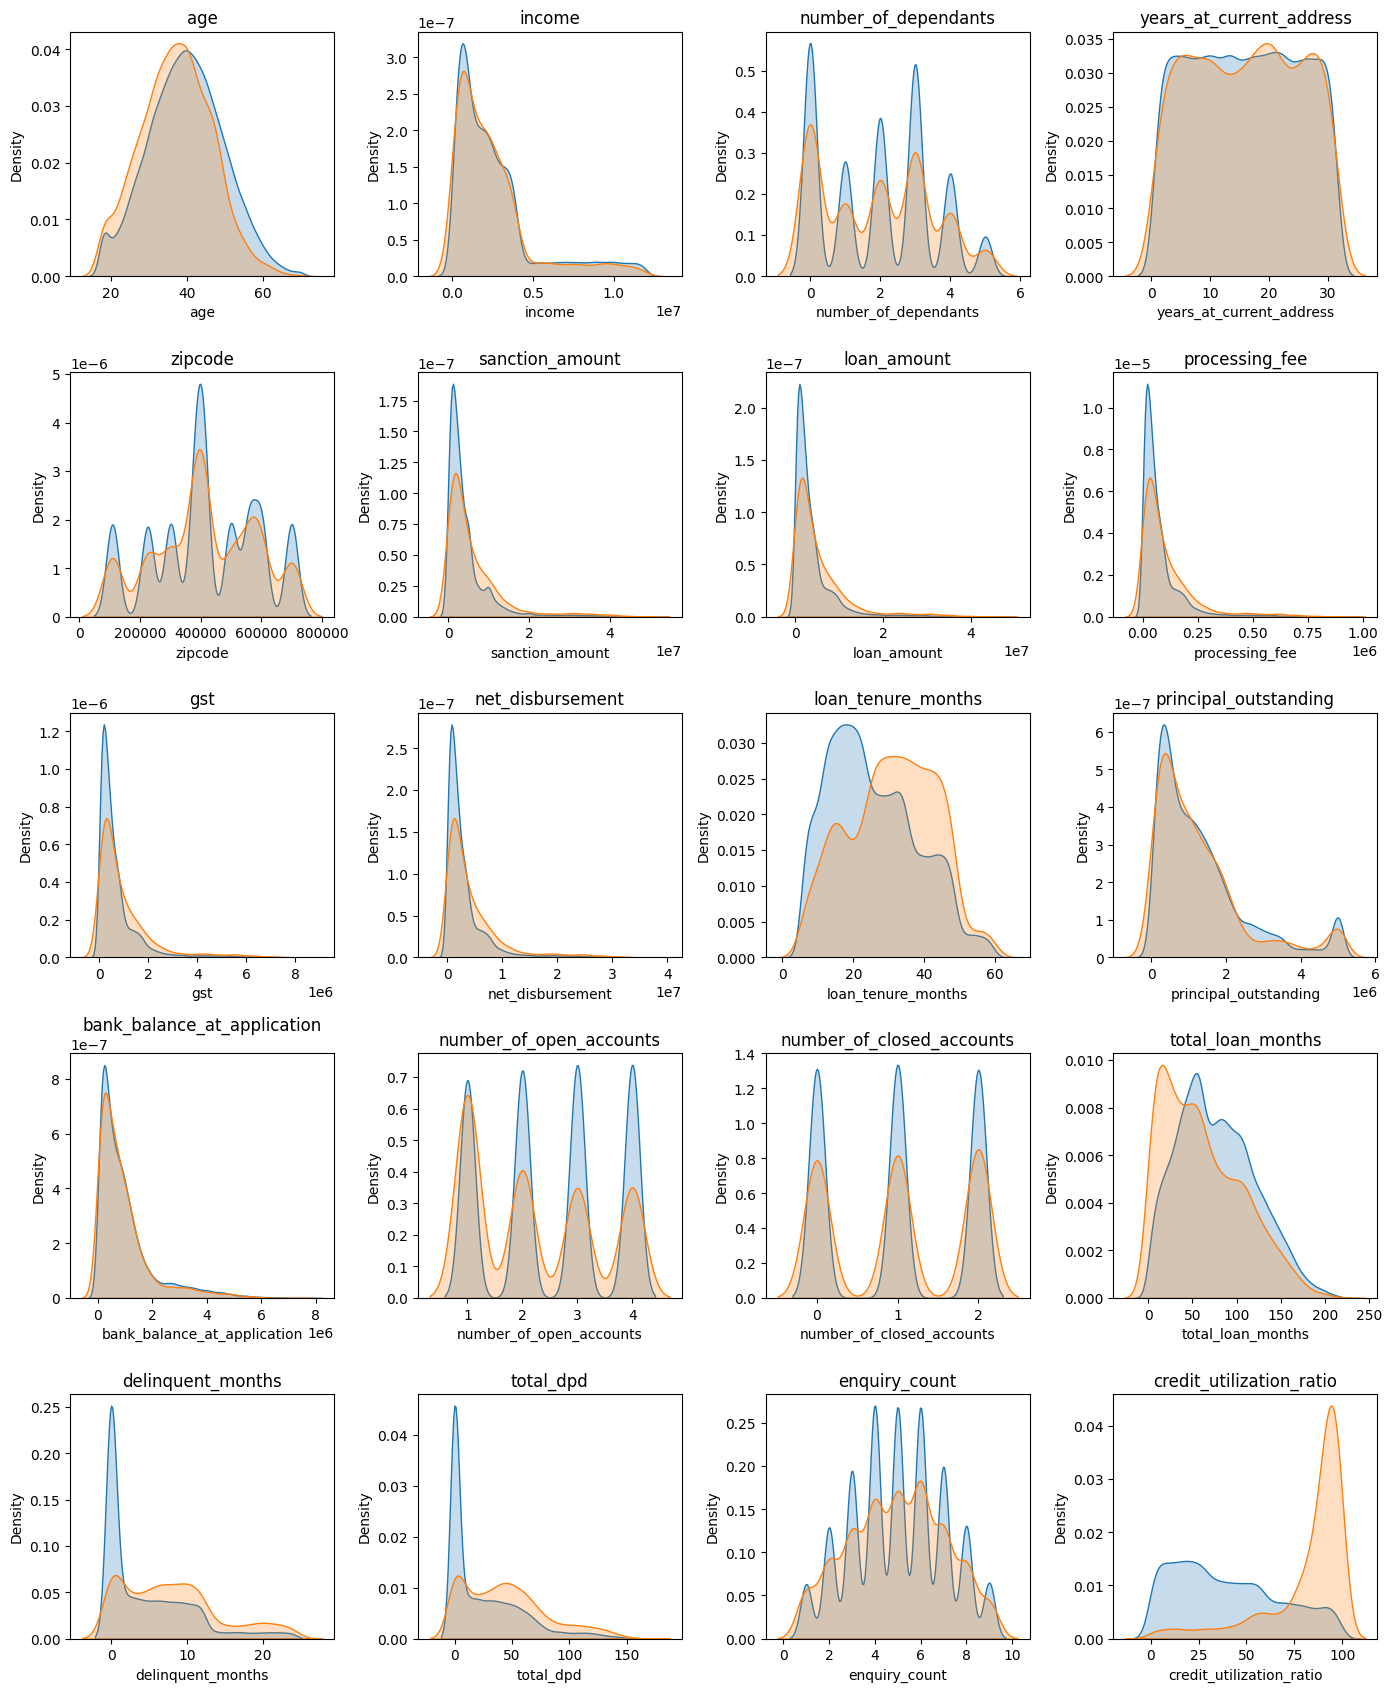

In [73]:
plt.figure(figsize=(14,20))
for i,col in enumerate(numerical_cols):

  plt.subplot(6,4,i+1)
  sns.kdeplot(df_train[col][df_train['default']==0],fill=True,label='Default=0')
  sns.kdeplot(df_train[col][df_train['default']==1],fill=True,label='Default=1')
  plt.title(col)


plt.tight_layout()
plt.show()


## Feature Engineering

In [74]:
# The income you earn and the loan amount you requested (LIT ration)
df_train['loan_to_income'] = (df_train['loan_amount']/df_train['income']).round(2)
df_test['loan_to_income'] = (df_test['loan_amount']/df_test['income']).round(2)

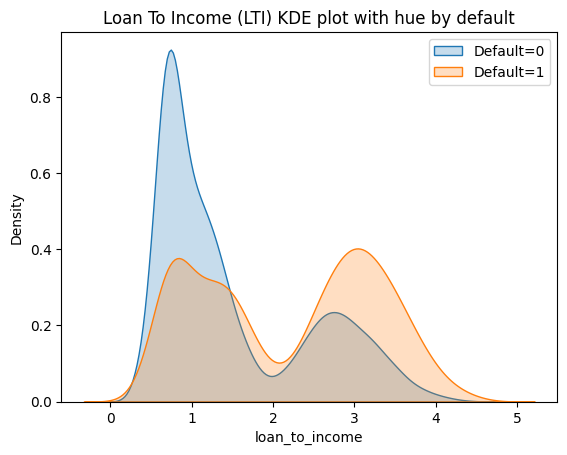

In [75]:
sns.kdeplot(df_train[df_train['default']==0]['loan_to_income'],fill=True,label='Default=0')
sns.kdeplot(df_train[df_train['default']==1]['loan_to_income'],fill=True,label='Default=1')
plt.title('Loan To Income (LTI) KDE plot with hue by default')
plt.legend()
plt.show()
# the plot shows the higher the ratio more likely it is default

In [76]:
df_train.head()

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,default,loan_to_income
12746,C12747,59,M,Married,Self-Employed,11327000,3,Owned,30,Hyderabad,Telangana,500001,L12747,Home,Secured,33121000,23442000,468840.00,4219560,18753600,28,5000000,4820526,2020-10-31,2020-11-11,4,2,152,20,118,4,36,0,2.07
32495,C32496,44,F,Single,Salaried,715000,0,Owned,27,Mumbai,Maharashtra,400001,L32496,Education,Secured,1175000,1149000,22980.00,206820,919200,50,467229,216697,2022-10-22,2022-10-27,3,1,160,10,62,5,5,0,1.61
43675,C43676,38,M,Single,Salaried,3195000,0,Mortgage,26,Chennai,Tamil Nadu,600001,L43676,Home,Secured,11409000,11296000,225920.00,2033280,9036800,32,1656773,1383842,2023-12-04,2023-12-29,1,1,54,12,67,4,0,0,3.54
9040,C09041,42,M,Married,Salaried,1500000,2,Mortgage,30,Bangalore,Karnataka,560001,L09041,Education,Secured,2336000,1695000,33900.00,305100,1356000,40,1023442,626203,2020-06-18,2020-07-07,3,0,76,0,0,8,87,0,1.13
13077,C13078,58,M,Married,Self-Employed,1817000,4,Owned,29,Pune,Maharashtra,411001,L13078,Personal,Unsecured,1167000,905000,18100.00,162900,724000,15,651599,585099,2020-11-12,2020-12-07,1,2,60,0,0,1,71,0,0.50


In [77]:
# Delinquency ratio [percentage of loans that are past due]
df_train['delinquency_ratio'] = (df_train['delinquent_months']*100/df_train['total_loan_months'].round(2))
df_test['delinquency_ratio'] = (df_test['delinquent_months']*100/df_test['total_loan_months'].round(2))

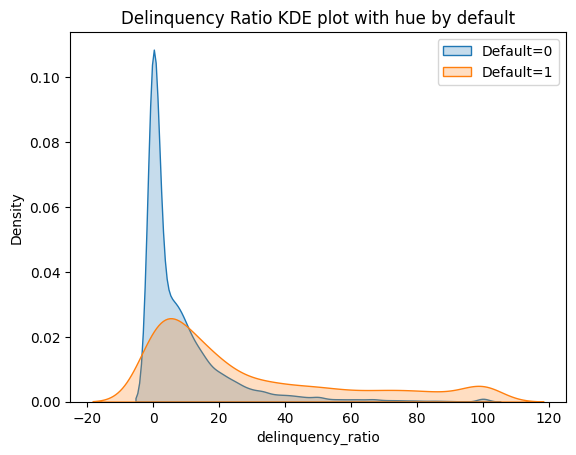

In [78]:
sns.kdeplot(df_train[df_train['default']==0]['delinquency_ratio'],fill=True,label='Default=0')
sns.kdeplot(df_train[df_train['default']==1]['delinquency_ratio'],fill=True,label='Default=1')
plt.title('Delinquency Ratio KDE plot with hue by default')
plt.legend()
plt.show()
# the plot shows where the Delinquency ratio is lower(blue color) the default is 0

In [79]:
# Average DPD for the Delinquency
# how many average days per delinquent months the customer delayed to pay

df_train['avg_dpd_per_delinquency'] = np.where(df_train['delinquent_months']>0,
         (df_train['total_dpd']/df_train['delinquent_months']).round(2),0)
df_test['avg_dpd_per_delinquency']  = np.where(df_test['delinquent_months']>0,
         (df_test['total_dpd']/df_test['delinquent_months']).round(2),0)

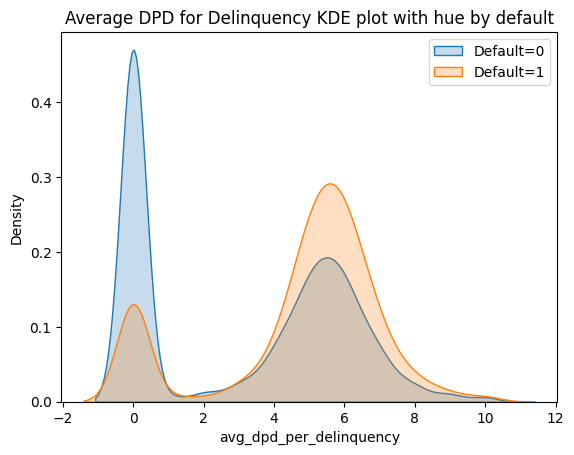

In [80]:
sns.kdeplot(df_train[df_train['default']==0]['avg_dpd_per_delinquency'],fill=True,label='Default=0')
sns.kdeplot(df_train[df_train['default']==1]['avg_dpd_per_delinquency'],fill=True,label='Default=1')
plt.title('Average DPD for Delinquency KDE plot with hue by default')
plt.legend()
plt.show()

## Feature Selection

In [81]:
df_train.columns

Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
       'income', 'number_of_dependants', 'residence_type',
       'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
       'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'disbursal_date', 'installment_start_dt', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio', 'default',
       'loan_to_income', 'delinquency_ratio', 'avg_dpd_per_delinquency'],
      dtype='object')

In [82]:
df_train = df_train.drop(['cust_id','loan_id'],axis=1)
df_test = df_test.drop(['cust_id','loan_id'],axis=1)
df_train = df_train.drop(['sanction_amount','disbursal_date', 'installment_start_dt','income','loan_amount',
                          'total_loan_months', 'delinquent_months', 'total_dpd'],axis='columns')
df_test = df_test.drop(  ['sanction_amount','disbursal_date', 'installment_start_dt','income',
                          'loan_amount','total_loan_months', 'delinquent_months', 'total_dpd'],axis='columns')

In [83]:
df_train_1 = df_train.copy()


### VIF Score

In [84]:
df_train_1.select_dtypes(['int64','float64']).columns

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [85]:
X_train = df_train_1.drop('default',axis=1)
y_train = df_train_1['default']

cols_to_scale = df_train_1.select_dtypes(['int64','float64']).columns

scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_train.describe()

,age,number_of_dependants,years_at_current_address,zipcode,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
count,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00
mean,0.41,0.39,0.50,0.52,0.08,0.08,0.08,0.38,0.26,0.12,0.50,0.50,0.50,0.44,0.29,0.10,0.33
std,0.19,0.31,0.30,0.29,0.11,0.11,0.11,0.23,0.24,0.13,0.37,0.41,0.25,0.30,0.23,0.17,0.29
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.29,0.00,0.23,0.33,0.02,0.02,0.02,0.19,0.08,0.03,0.00,0.00,0.38,0.18,0.11,0.00,0.00
50%,0.40,0.40,0.50,0.49,0.05,0.05,0.05,0.34,0.19,0.08,0.67,0.50,0.50,0.39,0.20,0.04,0.43
75%,0.54,0.60,0.77,0.76,0.10,0.10,0.10,0.55,0.35,0.16,1.00,1.00,0.62,0.68,0.51,0.13,0.57
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [86]:
X_test = df_test.drop('default',axis=1)
y_test = df_test['default']

X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_test.describe()

,age,number_of_dependants,years_at_current_address,zipcode,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
count,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00
mean,0.42,0.38,0.50,0.53,0.08,0.08,0.08,0.38,0.26,0.12,0.50,0.50,0.50,0.44,0.29,0.11,0.33
std,0.19,0.31,0.30,0.29,0.11,0.11,0.11,0.23,0.25,0.13,0.37,0.41,0.25,0.30,0.23,0.17,0.29
min,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.29,0.00,0.23,0.33,0.02,0.02,0.02,0.19,0.08,0.03,0.00,0.00,0.38,0.18,0.11,0.00,0.00
50%,0.42,0.40,0.50,0.51,0.05,0.05,0.05,0.34,0.20,0.08,0.33,0.50,0.50,0.39,0.20,0.04,0.44
75%,0.54,0.60,0.77,0.76,0.09,0.09,0.09,0.55,0.36,0.16,0.67,1.00,0.62,0.68,0.50,0.13,0.58
max,1.00,1.00,1.00,1.00,0.96,0.96,0.96,1.00,1.00,0.94,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [87]:
def calculate_vif(data):
  vif_df =  pd.DataFrame()
  vif_df['columns'] = data.columns
  vif_df['vif']     = [variance_inflation_factor(data.values,i)for i in range(data.shape[1])]

  return vif_df


In [88]:
calculate_vif(X_train[cols_to_scale])

,columns,vif
0,age,5.69
1,number_of_dependants,2.73
2,years_at_current_address,3.42
3,zipcode,3.80
4,processing_fee,inf
5,gst,inf
6,net_disbursement,inf
7,loan_tenure_months,6.10
8,principal_outstanding,16.26
9,bank_balance_at_application,9.34


In [89]:
features_to_drop_vif  = ['processing_fee','gst','net_disbursement','principal_outstanding']
X_train_1 = X_train.drop(features_to_drop_vif,axis=1)
numeric_cols = X_train_1.select_dtypes(['int64','float64']).columns
numeric_cols

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [90]:
vif_df = calculate_vif(X_train_1[numeric_cols])
vif_df

,columns,vif
0,age,5.43
1,number_of_dependants,2.73
2,years_at_current_address,3.40
3,zipcode,3.78
4,loan_tenure_months,6.02
5,bank_balance_at_application,1.80
6,number_of_open_accounts,4.35
7,number_of_closed_accounts,2.37
8,enquiry_count,6.38
9,credit_utilization_ratio,2.92


In [91]:
selected_numeric_features_vif = vif_df['columns'].values
selected_numeric_features_vif

array(['age', 'number_of_dependants', 'years_at_current_address',
       'zipcode', 'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts',
       'enquiry_count', 'credit_utilization_ratio', 'loan_to_income',
       'delinquency_ratio', 'avg_dpd_per_delinquency'], dtype=object)

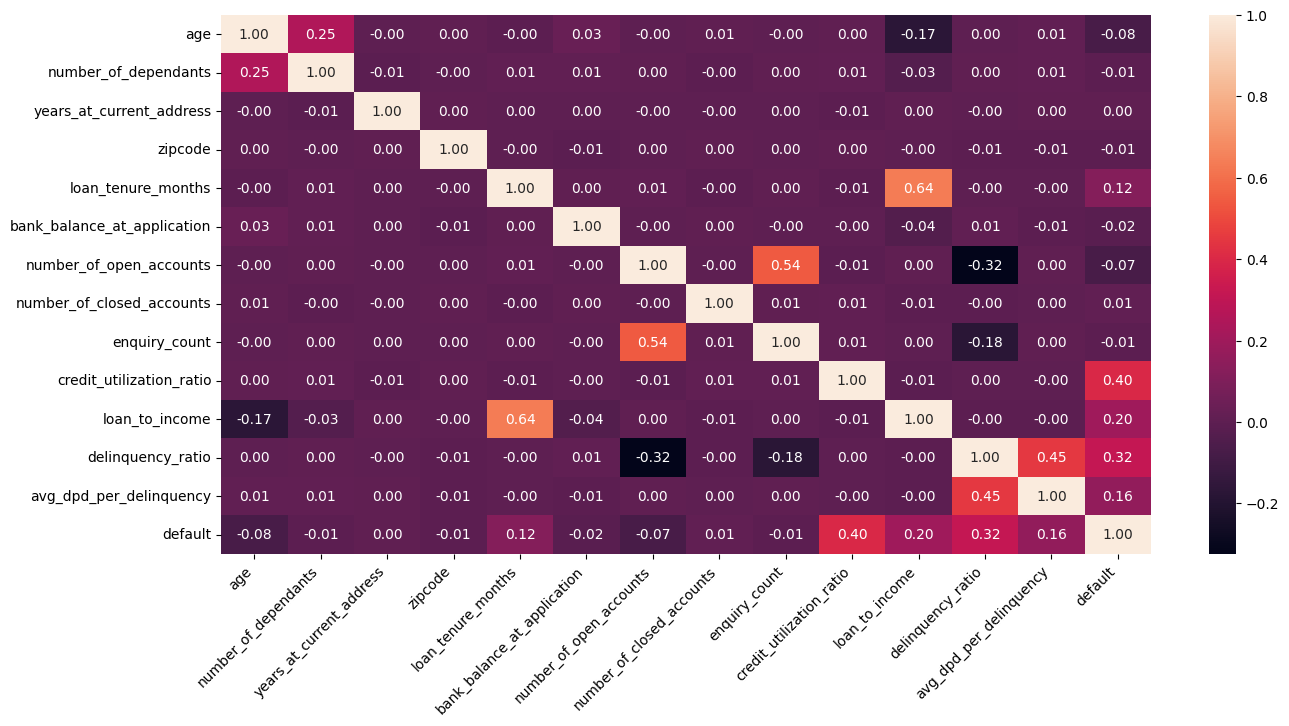

In [92]:
plt.figure(figsize=(15,7))
cm = df_train_1[numeric_cols.append(pd.Index(['default']))].corr()
sns.heatmap(cm,annot=True,fmt='0.2f')
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.show()

### WOE &  IV
- Weight of Evidence, Information *Value*

In [93]:
categorical_cols

['gender',
 'marital_status',
 'employment_status',
 'residence_type',
 'city',
 'state',
 'loan_purpose',
 'loan_type']

In [94]:
def calculate_woe_iv(df,feature,target):
  grouped = df.groupby(feature)[target].agg(['count','sum'])
  grouped = grouped.rename(columns={'count':'total','sum':'good'})
  grouped['bad'] = grouped['total']-grouped['good']

  total_good = grouped['good'].sum()
  total_bad  = grouped['bad'].sum()

  grouped['good_pct'] = grouped['good']/total_good
  grouped['bad_pct']  = grouped['bad']/total_bad
  grouped['woe']      = np.log( grouped['good_pct']/grouped['bad_pct'])
  grouped['iv']       = grouped['woe']*(grouped['good_pct']-grouped['bad_pct'])
  grouped['woe']      = grouped['woe'].replace([np.inf, -np.inf],0)
  grouped['iv']       = grouped['iv'].replace([np.inf, -np.inf],0)

  total_iv            = grouped['iv'].sum()
  return grouped,total_iv




In [95]:
grouped, total_iv = calculate_woe_iv(pd.concat([X_train_1,y_train],axis=1),'loan_purpose','default')
grouped

,total,good,bad,good_pct,bad_pct,woe,iv
loan_purpose,,,,,,,
Auto,7447,327,7120,0.10,0.21,-0.72,0.08
Education,5620,559,5061,0.17,0.15,0.16,0.00
Home,11304,1734,9570,0.54,0.28,0.66,0.17
Personal,13117,603,12514,0.19,0.37,-0.67,0.12


In [96]:
iv_values = {}
for feature in X_train_1.columns:
  if X_train_1[feature].dtype =='object':
    _, total_iv = calculate_woe_iv(pd.concat([X_train_1,y_train],axis=1),feature,'default')
  else:
    X_binned = pd.cut(X_train_1[feature],bins=10,labels=False)
    _, total_iv = calculate_woe_iv(pd.concat([X_binned,y_train],axis=1),feature,'default')
  iv_values[feature] = total_iv


iv_values



{'age': np.float64(0.0890689462679479),
 'gender': np.float64(0.00047449502170914947),
 'marital_status': np.float64(0.001129766845390142),
 'employment_status': np.float64(0.003953046301722585),
 'number_of_dependants': np.float64(0.0019380899135053508),
 'residence_type': np.float64(0.246745268718145),
 'years_at_current_address': np.float64(0.0020800513608156363),
 'city': np.float64(0.0019059578709781529),
 'state': np.float64(0.0019005589806779287),
 'zipcode': np.float64(0.0016677413243392572),
 'loan_purpose': np.float64(0.3691197842282755),
 'loan_type': np.float64(0.16319324904149224),
 'loan_tenure_months': np.float64(0.21893515090196278),
 'bank_balance_at_application': np.float64(0.0063187993277516365),
 'number_of_open_accounts': np.float64(0.08463134083005877),
 'number_of_closed_accounts': np.float64(0.0011964272592421567),
 'enquiry_count': np.float64(0.007864214085342608),
 'credit_utilization_ratio': np.float64(2.352965568168245),
 'loan_to_income': np.float64(0.47641

In [97]:
iv_df = pd.DataFrame(list(iv_values.items()),columns =['Feature','iv'])
iv_df = iv_df.sort_values(by='iv',ascending=False)
iv_df

,Feature,iv
17,credit_utilization_ratio,2.35
19,delinquency_ratio,0.72
18,loan_to_income,0.48
20,avg_dpd_per_delinquency,0.40
10,loan_purpose,0.37
5,residence_type,0.25
12,loan_tenure_months,0.22
11,loan_type,0.16
0,age,0.09
14,number_of_open_accounts,0.08


In [98]:
selected_features_iv = [feature for feature,iv in iv_values.items() if iv >0.02]
selected_features_iv

['age',
 'residence_type',
 'loan_purpose',
 'loan_type',
 'loan_tenure_months',
 'number_of_open_accounts',
 'credit_utilization_ratio',
 'loan_to_income',
 'delinquency_ratio',
 'avg_dpd_per_delinquency']

## Feature Encoding

In [99]:
X_train_reduced = X_train_1[selected_features_iv]
X_test_reduced = X_test[selected_features_iv]


In [100]:
X_train_encoded = pd.get_dummies(X_train_reduced,drop_first=True)
X_test_encoded  = pd.get_dummies(X_test_reduced,drop_first=True)



# Model Trainning and Tunning

## Attempt - 1
-  1.Logistic Regression, Random Froest, XGB
-  2.No handling Class Imbalance


In [101]:
model_lr = LogisticRegression()
model_lr.fit(X_train_encoded,y_train)
y_pred = model_lr.predict(X_test_encoded)

report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11423
           1       0.85      0.72      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.91      0.85      0.88     12497
weighted avg       0.96      0.96      0.96     12497



In [102]:
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train_encoded,y_train)
y_pred = model_rfc.predict(X_test_encoded)

report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11423
           1       0.85      0.71      0.77      1074

    accuracy                           0.96     12497
   macro avg       0.91      0.85      0.88     12497
weighted avg       0.96      0.96      0.96     12497



In [103]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_encoded,y_train)
y_pred = model_xgb.predict(X_test_encoded)

report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11423
           1       0.83      0.75      0.79      1074

    accuracy                           0.97     12497
   macro avg       0.90      0.87      0.89     12497
weighted avg       0.96      0.97      0.96     12497



In [104]:
param_dist={
    'C' : np.logspace(-4, 4, 20),
    'solver':['ibfgs','saga','liblinear','newton-cg']
}

log_reg = LogisticRegression(max_iter=10000)

random_search = RandomizedSearchCV(
    estimator = log_reg,
    param_distributions = param_dist,
    n_iter =50,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1

)

random_search.fit(X_train_encoded, y_train)

print("Best Parameters:", random_search.best_params_)
print('Best Score:',random_search.best_score_)



best_model = random_search.best_estimator_


y_pred = best_model.predict(X_test_encoded)
print(classification_report(y_test,y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'solver': 'newton-cg', 'C': np.float64(545.5594781168514)}
Best Score: 0.7578884658937152
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11423
           1       0.83      0.74      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.90      0.86      0.88     12497
weighted avg       0.96      0.96      0.96     12497



In [105]:

param_dist = {
'n_estimators': [100, 150, 200, 250, 300],
'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
'scale_pos_weight': [1, 2, 3, 5, 7, 10],
'reg_alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0], # L1 regularization term
'reg_lambda': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0] # L2 regularization term

}


xgb = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100,
scoring='f1', cv=3,verbose=1,random_state=42,n_jobs=-1)

random_search.fit(X_train_encoded, y_train)


print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.9, 'scale_pos_weight': 2, 'reg_lambda': 10.0, 'reg_alpha': 10.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best Score: 0.7873262253960208
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11423
           1       0.78      0.82      0.80      1074

    accuracy                           0.96     12497
   macro avg       0.88      0.90      0.89     12497
weighted avg       0.97      0.96      0.96     12497



## Attempt-2
- 1. Logistic Regressor, XGB
- 2. Handling the class imbalance using the undersamplint

In [106]:
rus  = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_encoded,y_train)
y_train_rus.value_counts()

,count
default,
0,3223
1,3223


In [107]:
model_lr = LogisticRegression()
model_lr.fit(X_train_rus,y_train_rus)
y_pred = model_lr.predict(X_test_encoded)

report = classification_report(y_test,y_pred)
print(report)
# precision increas the human intervention

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     11423
           1       0.51      0.95      0.67      1074

    accuracy                           0.92     12497
   macro avg       0.75      0.93      0.81     12497
weighted avg       0.95      0.92      0.93     12497



In [108]:
model_xgb = XGBClassifier(**random_search.best_params_)
model_xgb.fit(X_train_rus,y_train_rus)
y_pred = model_xgb.predict(X_test_encoded)

report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     11423
           1       0.52      0.99      0.68      1074

    accuracy                           0.92     12497
   macro avg       0.76      0.95      0.82     12497
weighted avg       0.96      0.92      0.93     12497



## Attempt -3
- 1. Logistic Regression
- 2. oversampling using SMOTE TOEMK
- 3. Parameter tunning using optuna

In [109]:
smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_encoded,y_train)
y_train_smt.value_counts()

,count
default,
0,34198
1,34198


In [110]:
model_lr = LogisticRegression()
model_lr.fit(X_train_smt,y_train_smt)
y_pred = model_lr.predict(X_test_encoded)

report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.55      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.77      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



In [111]:
# Define the objective function for Optuna
def objective(trial):
  param = {
  'C': trial.suggest_float('C', 1e-4, 1e4, log=True), # Logarithmically spaced values
  'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'newton-cg' ]), # Solvers
  'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True), # Logarithmically spaced values for tolerance
  'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']) # Class weights
  }

  model = LogisticRegression( **param, max_iter=10000)

  # Calculate the cross-validated f1_score
  f1_scorer = make_scorer(f1_score, average='macro')
  scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs =- 1)

  return np.mean(scores)

study_logistic = optuna.create_study(direction='maximize')
study_logistic.optimize(objective, n_trials=50)

[I 2025-03-28 05:38:49,412] A new study created in memory with name: no-name-3f9e2179-b615-4865-8b47-b2400402b3ce
[I 2025-03-28 05:38:56,855] Trial 0 finished with value: 0.9295733796129065 and parameters: {'C': 0.5276889857816783, 'solver': 'newton-cg', 'tol': 0.01160514575346604, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9295733796129065.
[I 2025-03-28 05:38:57,508] Trial 1 finished with value: 0.8543102705905445 and parameters: {'C': 0.0002573090427304644, 'solver': 'lbfgs', 'tol': 0.00400541765531026, 'class_weight': None}. Best is trial 0 with value: 0.9295733796129065.
[I 2025-03-28 05:38:59,138] Trial 2 finished with value: 0.9459295531825062 and parameters: {'C': 1.9377123538410586, 'solver': 'saga', 'tol': 0.002319172792089425, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.9459295531825062.
[I 2025-03-28 05:39:02,070] Trial 3 finished with value: 0.9401875923400057 and parameters: {'C': 0.07589527986792295, 'solver': 'saga', 'tol': 1.0914849436972

In [112]:
print('Best trial:')
trial = study_logistic.best_trial
print(' F1-score: {}'.format(trial.value))
print(' Params: ')
for key, value in trial.params.items ():
  print('{}: {}'.format(key, value))

best_model_logistic = LogisticRegression( ** study_logistic.best_params)
best_model_logistic. fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_logistic.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

Best trial:
 F1-score: 0.9460774687944798
 Params: 
C: 3.0122070401314716
solver: saga
tol: 0.0008505154489938962
class_weight: None
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.56      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.78      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



## Attempt -4
- XG Boost
- Handel class Imbalance using SMTOTE Tomek
- parameter tunning using optuna

In [113]:
# Define the objective function for Optuna
def objective(trial):
  param = {
  'objective': 'binary:logistic',
  'eval_metric': 'logloss',
  'verbosity': 0,
  'booster': 'gbtree',
  'lambda': trial. suggest_float('lambda', 1e-3, 10.0, log=True),
  'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
  'subsample': trial. suggest_float('subsample', 0.4, 1.0),
  'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.4, 1.0),
  'max_depth': trial.suggest_int('max_depth', 3, 10),
  'eta': trial.suggest_float('eta', 0.01, 0.3),
  'gamma': trial. suggest_float('gamma', 0, 10),
  'scale_pos_weight': trial. suggest_float('scale_pos_weight', 1, 10),
  'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
  'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)

  }

  model = XGBClassifier(**param)

  # Calculate the cross-validated f1_score
  f1_scorer = make_scorer(f1_score, average='macro' )
  scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs =- 1)

  return np.mean(scores)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=50)

[I 2025-03-28 05:46:24,286] A new study created in memory with name: no-name-57d31835-37e5-4506-8b89-7c76ab2c76e0
[I 2025-03-28 05:46:28,924] Trial 0 finished with value: 0.9690858108297604 and parameters: {'lambda': 0.002177932424235539, 'alpha': 0.34589848966199405, 'subsample': 0.9240984600785531, 'colsample_bytree': 0.4176716856458415, 'max_depth': 10, 'eta': 0.178737694879712, 'gamma': 1.6108140388437953, 'scale_pos_weight': 9.021791940512248, 'min_child_weight': 1, 'max_delta_step': 6}. Best is trial 0 with value: 0.9690858108297604.
[I 2025-03-28 05:46:30,244] Trial 1 finished with value: 0.9473502046604914 and parameters: {'lambda': 1.1413766850954643, 'alpha': 6.031432266951881, 'subsample': 0.6111438689115724, 'colsample_bytree': 0.5834100575280436, 'max_depth': 3, 'eta': 0.14028280388798464, 'gamma': 1.1253619436993023, 'scale_pos_weight': 3.142663456521543, 'min_child_weight': 6, 'max_delta_step': 8}. Best is trial 0 with value: 0.9690858108297604.
[I 2025-03-28 05:46:32,47

In [114]:
print('Best trial:')
trial = study_xgb.best_trial
print(' F1-score: {}'.format(trial.value))
print(' Params: ')
for key, value in trial.params.items ():
  print('{}: {}'.format(key, value))

best_params = study_xgb.best_params
best_model_xgb = XGBClassifier( ** best_params)
best_model_xgb.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_xgb.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)


Best trial:
 F1-score: 0.9767482111030219
 Params: 
lambda: 0.005008273183173745
alpha: 0.5517204391942813
subsample: 0.9586663964917983
colsample_bytree: 0.547461169192967
max_depth: 10
eta: 0.1706276374193505
gamma: 0.49290428681710485
scale_pos_weight: 1.6399339665527897
min_child_weight: 1
max_delta_step: 9
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11423
           1       0.71      0.85      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.85      0.91      0.88     12497
weighted avg       0.96      0.96      0.96     12497



In [115]:
y_pred = best_model_logistic.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.56      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.78      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



In [118]:
probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities)
fpr[:10], tpr[:10], thresholds [ : 10]

(array([0.        , 0.        , 0.        , 0.00008754, 0.00008754,
        0.00017509, 0.00017509, 0.00026263, 0.00026263, 0.00035017]),
 array([0.        , 0.0009311 , 0.16201117, 0.16201117, 0.17783985,
        0.17783985, 0.21787709, 0.21787709, 0.22998138, 0.22998138]),
 array([       inf, 1.        , 0.99942926, 0.99942125, 0.99927934,
        0.99927713, 0.99873188, 0.99870926, 0.99839383, 0.99838997]))

In [119]:
area = auc(fpr, tpr)
area


np.float64(0.9836762251206401)

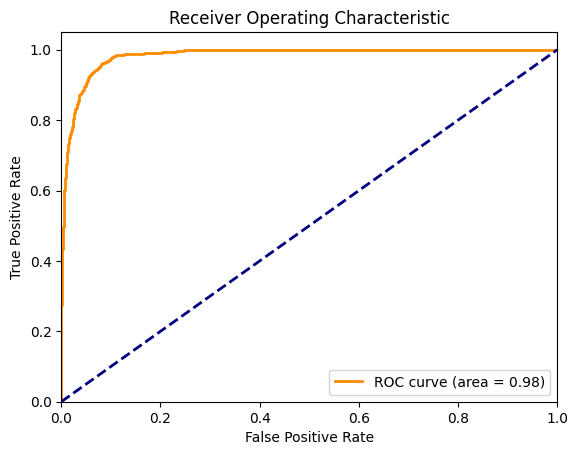

In [121]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Model Evaluation

## Rank ordering and KStastict

In [125]:
probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]

df_eval = pd.DataFrame({
    'Default_truth':y_test,
    'Default_probability':probabilities
})
df_eval.head()

,Default_truth,Default_probability
19205,0,0.53
15514,0,0.00
30367,0,0.01
35347,0,0.01
41814,1,0.92


In [129]:
# calculate decile
df_eval['decile'] = pd.qcut(df_eval['Default_probability'],10,duplicates='drop',labels=False,)

In [133]:
df_grouped = df_eval.groupby('decile').apply(lambda x: pd.Series({
'Minimum Probability': x['Default_probability'].min(),
'Maximum Probability': x['Default_probability'].max(),
'Events': x['Default_truth'].sum( ),
'Non-events': x['Default_truth'].count() - x['Default_truth'].sum(),
}))
df_grouped.reset_index(inplace=True)
df_grouped

,decile,Minimum Probability,Maximum Probability,Events,Non-events
0,0,0.00,0.00,0.00,1250.00
1,1,0.00,0.00,0.00,1250.00
2,2,0.00,0.00,0.00,1249.00
3,3,0.00,0.00,0.00,1250.00
4,4,0.00,0.00,0.00,1250.00
5,5,0.00,0.00,0.00,1249.00
6,6,0.00,0.03,5.00,1245.00
7,7,0.03,0.21,10.00,1239.00
8,8,0.21,0.82,162.00,1088.00
9,9,0.82,1.00,897.00,353.00


In [134]:
df_grouped['Event Rate'] = df_grouped['Events' ]*100 / (df_grouped['Events' ]+df_grouped['Non-events' ])
df_grouped['Non-event Rate'] = df_grouped['Non-events' ]*100 / (df_grouped['Events' ]+df_grouped['Non-events' ])
df_grouped

,decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,0,0.00,0.00,0.00,1250.00,0.00,100.00
1,1,0.00,0.00,0.00,1250.00,0.00,100.00
2,2,0.00,0.00,0.00,1249.00,0.00,100.00
3,3,0.00,0.00,0.00,1250.00,0.00,100.00
4,4,0.00,0.00,0.00,1250.00,0.00,100.00
5,5,0.00,0.00,0.00,1249.00,0.00,100.00
6,6,0.00,0.03,5.00,1245.00,0.40,99.60
7,7,0.03,0.21,10.00,1239.00,0.80,99.20
8,8,0.21,0.82,162.00,1088.00,12.96,87.04
9,9,0.82,1.00,897.00,353.00,71.76,28.24


In [135]:
df_grouped = df_grouped.sort_values(by='decile',ascending=False).reset_index(drop=False)
df_grouped

,index,decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,9,9,0.82,1.00,897.00,353.00,71.76,28.24
1,8,8,0.21,0.82,162.00,1088.00,12.96,87.04
2,7,7,0.03,0.21,10.00,1239.00,0.80,99.20
3,6,6,0.00,0.03,5.00,1245.00,0.40,99.60
4,5,5,0.00,0.00,0.00,1249.00,0.00,100.00
5,4,4,0.00,0.00,0.00,1250.00,0.00,100.00
6,3,3,0.00,0.00,0.00,1250.00,0.00,100.00
7,2,2,0.00,0.00,0.00,1249.00,0.00,100.00
8,1,1,0.00,0.00,0.00,1250.00,0.00,100.00
9,0,0,0.00,0.00,0.00,1250.00,0.00,100.00


In [137]:
df_grouped['Cum Events' ] = df_grouped['Events' ].cumsum()
df_grouped['Cum Non-events' ] = df_grouped['Non-events' ]. cumsum( )
df_grouped

,index,decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events
0,9,9,0.82,1.00,897.00,353.00,71.76,28.24,897.00,353.00
1,8,8,0.21,0.82,162.00,1088.00,12.96,87.04,1059.00,1441.00
2,7,7,0.03,0.21,10.00,1239.00,0.80,99.20,1069.00,2680.00
3,6,6,0.00,0.03,5.00,1245.00,0.40,99.60,1074.00,3925.00
4,5,5,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,5174.00
5,4,4,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,6424.00
6,3,3,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,7674.00
7,2,2,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,8923.00
8,1,1,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,10173.00
9,0,0,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,11423.00


In [138]:
df_grouped['Cum Event Rate' ] = df_grouped['Cum Events' ] * 100 / df_grouped['Events']. sum()
df_grouped['Cum Non-event Rate' ] = df_grouped['Cum Non-events' ]*100 / df_grouped['Non-events' ]. sum()
df_grouped

,index,decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate
0,9,9,0.82,1.00,897.00,353.00,71.76,28.24,897.00,353.00,83.52,3.09
1,8,8,0.21,0.82,162.00,1088.00,12.96,87.04,1059.00,1441.00,98.60,12.61
2,7,7,0.03,0.21,10.00,1239.00,0.80,99.20,1069.00,2680.00,99.53,23.46
3,6,6,0.00,0.03,5.00,1245.00,0.40,99.60,1074.00,3925.00,100.00,34.36
4,5,5,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,5174.00,100.00,45.29
5,4,4,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,6424.00,100.00,56.24
6,3,3,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,7674.00,100.00,67.18
7,2,2,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,8923.00,100.00,78.11
8,1,1,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,10173.00,100.00,89.06
9,0,0,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,11423.00,100.00,100.00


In [140]:
df_grouped['KS'] = abs(df_grouped['Cum Event Rate' ] - df_grouped['Cum Non-event Rate' ])
df_grouped

,index,decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate,KS
0,9,9,0.82,1.00,897.00,353.00,71.76,28.24,897.00,353.00,83.52,3.09,80.43
1,8,8,0.21,0.82,162.00,1088.00,12.96,87.04,1059.00,1441.00,98.60,12.61,85.99
2,7,7,0.03,0.21,10.00,1239.00,0.80,99.20,1069.00,2680.00,99.53,23.46,76.07
3,6,6,0.00,0.03,5.00,1245.00,0.40,99.60,1074.00,3925.00,100.00,34.36,65.64
4,5,5,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,5174.00,100.00,45.29,54.71
5,4,4,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,6424.00,100.00,56.24,43.76
6,3,3,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,7674.00,100.00,67.18,32.82
7,2,2,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,8923.00,100.00,78.11,21.89
8,1,1,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,10173.00,100.00,89.06,10.94
9,0,0,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,11423.00,100.00,100.00,0.00


To assess whether rank ordering is followed, we should look at whether higher deciles (those with higher predicted probabilities) have higher event rates compared to lower deciles. Rank ordering means that as you move from the top decile to the bottom decile, the event rate should generally decrease.

Non-Events - termed as good (customers) who do not default. Events - termed as bad (customers) who default.

Events and Non-Events terms are interchanged based on usecase to usecase.

eg: for marketing usecase, which customer to reach out (who will take loan based on offers) will be events - here it will termed as good, and the customers who will not take loans will be non-events (bad).

**Insights from the Decile Table**

1. Top Deciles

* The first decile (Decile 9) has a high event rate of 72.00% and a non-event rate of 28.00%. This indicates that the model is highly confident in predicting events in this decile.
* The second decile (Decile 8) also shows a significant event rate of 12.72%, with a cumulative event rate reaching 98.6%.

2. Middle Deciles:

* Deciles 7 and 6 show a significant drop in event rates

3. Lower Deciles:

* Deciles 5 to 0 show zero events, with all predictions being non-events. These deciles collectively have a non-event rate of 100%.

4. KS Statistic:

* The KS statistic, which is the maximum difference between cumulative event rates and cumulative non-event rates, is highest at Decile 8 with a value of 85.98%. This suggests that the model performs best at distinguishing between events and non-events up to this decile.

* The KS value gradually decreases in the following deciles, indicating a decrease in model performance for distinguishing between events and non-events.

**KS Value**

The highest KS value is 85.98%, found at Decile 8. This indicates that the model's performance in distinguishing between events and non-events is most significant at this decile. (If KS is in top 3 decile and score above 40, it is considered a good predictive model.)

## Gini coeff

In [144]:
gini_coefficient = 2 * area - 1

print("AUC:", area)
print("Gini Coefficient:", gini_coefficient)

AUC: 0.9836762251206401
Gini Coefficient: 0.9673524502412802


AUC of 0.98: The model is very good at distinguishing between events and non-events.

Gini coefficient of 0.96: This further confirms that the model is highly effective in its predictions, with almost perfect rank ordering capability.

The Gini coefficient ranges from -1 to 1, where a value closer to 1 signifies a perfect model, 0 indicates a model with no discriminative power, and -1 signifies a perfectly incorrect model.

## Finalize The Model and Visualize Feature Importance

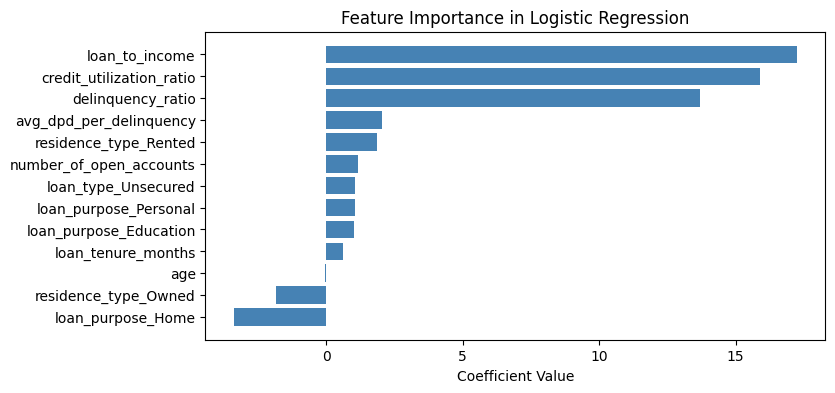

In [145]:
final_model = best_model_logistic

feature_importance = final_model.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

# Saving Model

In [141]:
X_test_encoded.head(3)

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
19205,0.35,0.75,0.33,0.99,0.55,0.00,0.00,True,False,False,True,False,False
15514,0.48,0.23,1.00,0.32,0.22,0.00,0.00,True,False,True,False,False,False
30367,0.23,0.55,0.67,0.83,0.18,0.00,0.00,True,False,False,False,False,False


In [142]:
X_test.columns

Index(['age', 'gender', 'marital_status', 'employment_status',
       'number_of_dependants', 'residence_type', 'years_at_current_address',
       'city', 'state', 'zipcode', 'loan_purpose', 'loan_type',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [143]:
cols_to_scale

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [147]:
X_train.columns

Index(['age', 'gender', 'marital_status', 'employment_status',
       'number_of_dependants', 'residence_type', 'years_at_current_address',
       'city', 'state', 'zipcode', 'loan_purpose', 'loan_type',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [149]:
model_data = {
    'model': final_model,
    'features': X_train_encoded.columns,
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(model_data, '/content/drive/MyDrive/code Basics/Project-2/artifacts/model_data.joblib')

['/content/drive/MyDrive/code Basics/Project-2/artifacts/model_data.joblib']

In [150]:
final_model.coef_, final_model.intercept_

(array([[-0.05115674,  0.61120182,  1.18063725, 15.90282935, 17.25727371,
         13.6866206 ,  2.04744914, -1.84580424,  1.84215684,  1.01264015,
         -3.39334952,  1.04970235,  1.04970235]]),
 array([-20.70196715]))